# Dealing with the data (Methodology)

The hospital price transparency files come in suprisingly, all csv formats. 
I applied the following **data standardization pipeline**:

1. **Loading & Parsing**  
   - Collected raw files from multiple hospitals (Mount Sinai, Johns Hopkins, Mayo Clinic, Cleveland Clinic).  
   - Parsed into Pandas DataFrames regardless of original format (CSV, XLSX, JSON).  

2. **Field Standardization**  
   - Unified naming across hospitals:  
     - `gross_charge` → list price  
     - `discounted_cash` → cash/self-pay price  
     - `code` → procedure code (CPT/DRG/etc.)  
     - `description` → procedure description  
     - `hospital` → hospital name  
     - `state` / `county` → location metadata (if available)  

3. **Data Cleaning**  
   - Removed empty rows and irrelevant fields (e.g. internal IDs).  
   - Converted all numeric values to floats (USD).  
   - Applied log transform for visualization where price ranges span multiple orders of magnitude.  

4. **Merging**  
   - Combined all hospital-level DataFrames into a single standardized dataset.  
   - Ensured consistency by aligning column names to the schema below.  

---

### Final Schema

| Column Name       | Description                                      |
|-------------------|--------------------------------------------------|
| `hospital`        | Hospital name (e.g., Mount Sinai Brooklyn)       |
| `state`           | State abbreviation (if available)                |
| `county`          | County name (if available)                       |
| `code`            | Procedure code (e.g., CPT/DRG)                   |
| `description`     | Procedure description (if available)             |
| `gross_charge`    | Published list price                             |
| `discounted_cash` | Self-pay / discounted cash price                  |
| `payer`           | Payer/insurance identifier (if available)        |
| `effective_date`  | Date of pricing file (if available)              |

---

This schema allows us to analyze **price distributions, discount patterns, and variation both within and across hospitals** in a consistent way.


In [14]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
from unify_schema import normalize_one_file, merge_and_save
from save_parquet import merge_and_save_parquet
DATA_FILES = [
    # (path, hospital_name, header_index)
    ("/Users/chunyiyang/hospital-price-transparency/data/520591656_JohnsHopkinsHospital_standardcharges.csv",                "Johns Hopkins Hospital", 2),
    ("/Users/chunyiyang/hospital-price-transparency/data/860800150_mayo-clinic-arizona_standardcharges.csv",       "Mayo Clinic Arizona",    2),
    ("/Users/chunyiyang/hospital-price-transparency/data/135564934_mount-sinai-brooklyn_standardcharges.csv", "Mount Sinai Brooklyn", 2),
    ("/Users/chunyiyang/hospital-price-transparency/data/340714585_the-cleveland-clinic-foundation_standardcharges.csv",   "Cleveland Clinic",       2),
]

OUT_CSV = "./processed/merged_standardized.csv"

def main():
    normalized_list = []
    for path, hosp, hdr in DATA_FILES:
        print(f"[+] Normalizing: {hosp}  <- {path}")
        df_std = normalize_one_file(path=path, hospital_name=hosp, header=hdr)
        print(f"    Rows: {len(df_std)}, Columns: {len(df_std.columns)}")
        price_cols = ["gross_charge","discounted_cash","negotiated_dollar","min_charge","max_charge"]
        present = [c for c in price_cols if c in df_std.columns]
        if present:
            nonnull = df_std[present].notna().sum().to_dict()
            print(f"    Non-null price cells: {nonnull}")
        normalized_list.append(df_std)

    merged = merge_and_save(normalized_list, OUT_CSV)
    print(f"\n[✓] Merged saved to: {OUT_CSV}")
    print(f"    Total rows: {len(merged)}")
    
    OUT_PARQUET = "./processed/merged_standardized.parquet"
    merged = merge_and_save_parquet(normalized_list, OUT_PARQUET)
    print(f"[✓] Parquet saved to: {OUT_PARQUET}, rows={len(merged)}")

    preview_cols = ["hospital","description","code","code_type","gross_charge","discounted_cash","negotiated_dollar","min_charge","max_charge","payer_name","plan_name"]
    preview_cols = [c for c in preview_cols if c in merged.columns]
    print("\n[Preview]")
    print(merged[preview_cols].head(5).to_string(index=False))

if __name__ == "__main__":
    main()





[+] Normalizing: Johns Hopkins Hospital  <- /Users/chunyiyang/hospital-price-transparency/data/520591656_JohnsHopkinsHospital_standardcharges.csv
    Rows: 31222, Columns: 25
    Non-null price cells: {'gross_charge': 14701, 'discounted_cash': 14701, 'negotiated_dollar': 0, 'min_charge': 15791, 'max_charge': 15791}
[+] Normalizing: Mayo Clinic Arizona  <- /Users/chunyiyang/hospital-price-transparency/data/860800150_mayo-clinic-arizona_standardcharges.csv
    Rows: 2261469, Columns: 25
    Non-null price cells: {'gross_charge': 2220650, 'discounted_cash': 2220650, 'negotiated_dollar': 79489, 'min_charge': 2260384, 'max_charge': 2260384}
[+] Normalizing: Mount Sinai Brooklyn  <- /Users/chunyiyang/hospital-price-transparency/data/135564934_mount-sinai-brooklyn_standardcharges.csv
    Rows: 13097687, Columns: 25
    Non-null price cells: {'gross_charge': 11671431, 'discounted_cash': 900000, 'negotiated_dollar': 2199318, 'min_charge': 13097687, 'max_charge': 13097687}
[+] Normalizing: Cleve

/Users/chunyiyang/hospital-price-transparency/unify_schema.py:216: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged = pd.concat(dfs, ignore_index=True)



[✓] Merged saved to: ./processed/merged_standardized.csv
    Total rows: 18821983


/Users/chunyiyang/hospital-price-transparency/save_parquet.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged = pd.concat(dfs, ignore_index=True)


[✓] Parquet saved to: ./processed/merged_standardized.parquet, rows=18821983

[Preview]
              hospital                             description code code_type  gross_charge  discounted_cash  negotiated_dollar  min_charge  max_charge     payer_name                 plan_name
Johns Hopkins Hospital New Technology - Level 22 ($2001-$2500) 1522       APC           NaN              NaN                NaN     2659.27    17544.82          Aetna     Aetna Meritain Health
Johns Hopkins Hospital New Technology - Level 22 ($2001-$2500) 1522       APC           NaN              NaN                NaN     2659.27    17544.82          Aetna Aetna Health Network Only
Johns Hopkins Hospital New Technology - Level 22 ($2001-$2500) 1522       APC           NaN              NaN                NaN     2659.27    17544.82          Aetna Aetna Choice Pos I And Ii
Johns Hopkins Hospital New Technology - Level 22 ($2001-$2500) 1522       APC           NaN              NaN                NaN     2659.27 

# Loading the data
we use the merged_standardize.parquet as it is faster than the csv format.

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

df = pd.read_parquet("./processed/merged_standardized.parquet")
print(df.shape)
df.head()

(18821983, 25)


,hospital,facility_id,description,code,code_type,billing_class,setting,drug_unit_of_measurement,drug_type_of_measurement,modifiers,...,estimated_amount,min_charge,max_charge,payer_name,plan_name,methodology,additional_notes,additional_payer_notes,count_of_compared_rates,footnote
0,Johns Hopkins Hospital,None,New Technology - Level 22 ($2001-$2500),1522,APC,facility,outpatient,NaN,None,None,...,8051.96,2659.27,17544.82,Aetna,Aetna Meritain Health,other,Contracting method is an algorithm described i...,None,NaN,None
1,Johns Hopkins Hospital,None,New Technology - Level 22 ($2001-$2500),1522,APC,facility,outpatient,NaN,None,None,...,3223.68,2659.27,17544.82,Aetna,Aetna Health Network Only,other,Contracting method is an algorithm described i...,None,NaN,None
2,Johns Hopkins Hospital,None,New Technology - Level 22 ($2001-$2500),1522,APC,facility,outpatient,NaN,None,None,...,8189.59,2659.27,17544.82,Aetna,Aetna Choice Pos I And Ii,other,Contracting method is an algorithm described i...,None,NaN,None
3,Johns Hopkins Hospital,None,New Technology - Level 22 ($2001-$2500),1522,APC,facility,outpatient,NaN,None,None,...,7554.00,2659.27,17544.82,Aetna Med Adv,Aetna Medicare Ppo,other,Contracting method is an algorithm described i...,None,NaN,None
4,Johns Hopkins Hospital,None,New Technology - Level 22 ($2001-$2500),1522,APC,facility,outpatient,NaN,None,None,...,8122.30,2659.27,17544.82,Blue Cr/Sh Fep,Blue Cr/Sh Fep Focus Ppo,other,Contracting method is an algorithm described i...,None,NaN,None


Getting the rows (We can see Mount Sinai has the biggest data set, and the record from JH hospital is comparatively small, therefore, we apply a log scale to show every hospital on this graph)

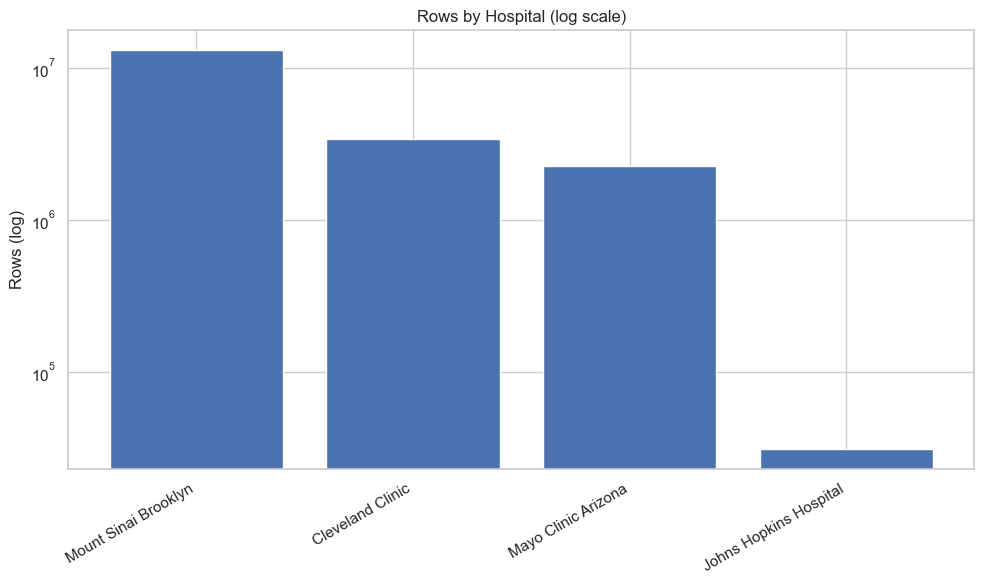

In [6]:
# Rows by hospital (log scale)
rows_by_hospital = df['hospital'].value_counts().rename('rows').reset_index().rename(columns={'index':'hospital'})

plt.figure()
plt.bar(rows_by_hospital['hospital'], rows_by_hospital['rows'])
plt.yscale("log")  
plt.title('Rows by Hospital (log scale)')
plt.xticks(rotation=30, ha='right')
plt.ylabel('Rows (log)')
plt.tight_layout()
plt.show()


# Distribution by code type within each hospital

This stacked bar chart shows the relative distribution of code types across four hospitals, normalized to 100% for each institution:

Mayo Clinic Arizona: Almost entirely dominated by CDM codes (98%), indicating a very homogeneous dataset focused on chargemaster items.

Mount Sinai Brooklyn: Also heavily CDM-driven (87%), but with a noticeable share of CPT codes (9%), reflecting a stronger emphasis on procedure-level billing.

Cleveland Clinic: More balanced, with CDM (70%) as the majority but also a significant proportion of NDC codes (26%), suggesting a large number of drug entries in their published data.

Johns Hopkins Hospital: The most diverse mix, including APC (22%), CDM (22%), and MS-DRG (28%), plus smaller contributions from other code types. This reflects a dataset that spans outpatient, inpatient, and general chargemaster categories.

**Key takeaway**: Hospitals vary widely in how they report codes. Some (Mayo, Sinai) concentrate on CDM-based pricing, while others (Cleveland, JHU) provide richer, more varied structures, which may affect comparability across institutions.

/var/folders/lj/20qxvm111sg60tvdf5yxflpr0000gn/T/ipykernel_23405/1980658121.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = (tmp.groupby(['hospital','code_type'])
/var/folders/lj/20qxvm111sg60tvdf5yxflpr0000gn/T/ipykernel_23405/1980658121.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total = tmp.groupby('hospital')['count'].transform('sum')


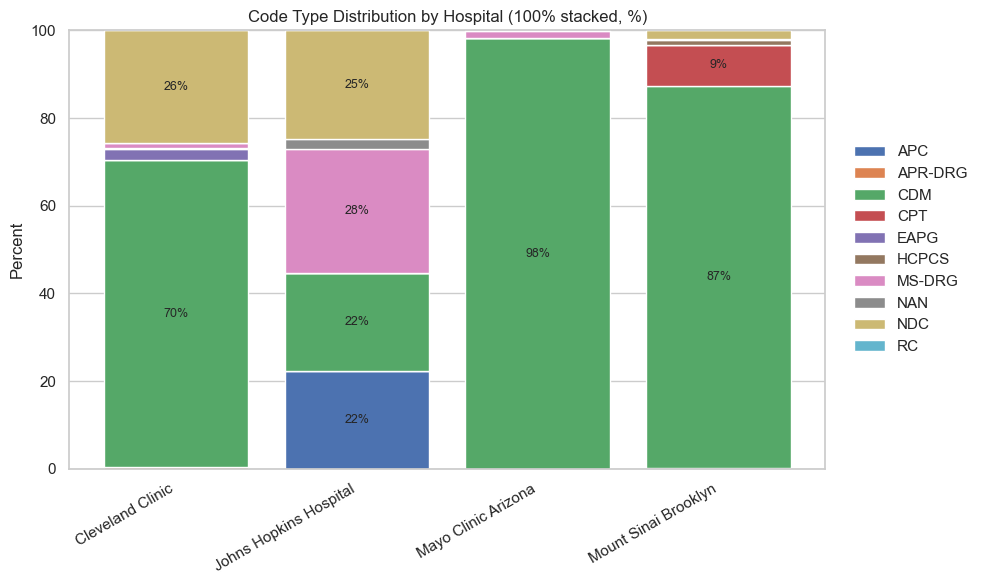

In [8]:
import numpy as np
import matplotlib.pyplot as plt

tmp = (df.assign(code_type=df['code_type'].astype(str).str.upper().str.strip()))
tmp = (tmp.groupby(['hospital','code_type'])
         .size()
         .rename('count')
         .reset_index())


total = tmp.groupby('hospital')['count'].transform('sum')
tmp['pct'] = tmp['count'] / total * 100


hospitals = tmp['hospital'].drop_duplicates().tolist()
code_types = sorted(tmp['code_type'].drop_duplicates().tolist())


pivot_pct = tmp.pivot(index='hospital', columns='code_type', values='pct').fillna(0.0)
pivot_pct = pivot_pct.reindex(hospitals)  

fig, ax = plt.subplots(figsize=(10, 6))

handles = []
labels  = []

bottom = np.zeros(len(pivot_pct), dtype=float)

for ct in code_types:
    vals = pivot_pct[ct].values if ct in pivot_pct.columns else np.zeros(len(pivot_pct))
    bars = ax.bar(pivot_pct.index, vals, bottom=bottom, label=ct)  # 不指定颜色，使用默认色板
    bottom = bottom + vals

    handles.append(bars)
    labels.append(ct)

    for i, v in enumerate(vals):
        if v >= 5:
            ax.text(i,                   
                    bottom[i] - v/2,     
                    f"{v:.0f}%",          
                    ha='center', va='center', fontsize=9)

ax.set_title('Code Type Distribution by Hospital (100% stacked, %)')
ax.set_ylabel('Percent')
plt.xticks(rotation=30, ha='right')

ax.set_ylim(0, 100)

legend = ax.legend(handles=[h[0] for h in handles], labels=labels,
                   loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout()
plt.show()


# Gross Charges vs. Discounted Cash Prices

- Gross Charges: inflated hospital list prices, rarely paid in full.  
- Discounted Cash Prices: actual upfront payments for self-pay patients.  
- Data fields: gross_charge and discounted_cash.

**Key Takeaways**  
- Gross charges span orders of magnitude, with extreme outliers.  
- Discounted cash prices are lower, less variable, but still spread.  
- Johns Hopkins: relatively lower charges.  
- Cleveland Clinic & Mount Sinai Brooklyn: broader ranges.  
- Log scale needed due to wide variation.


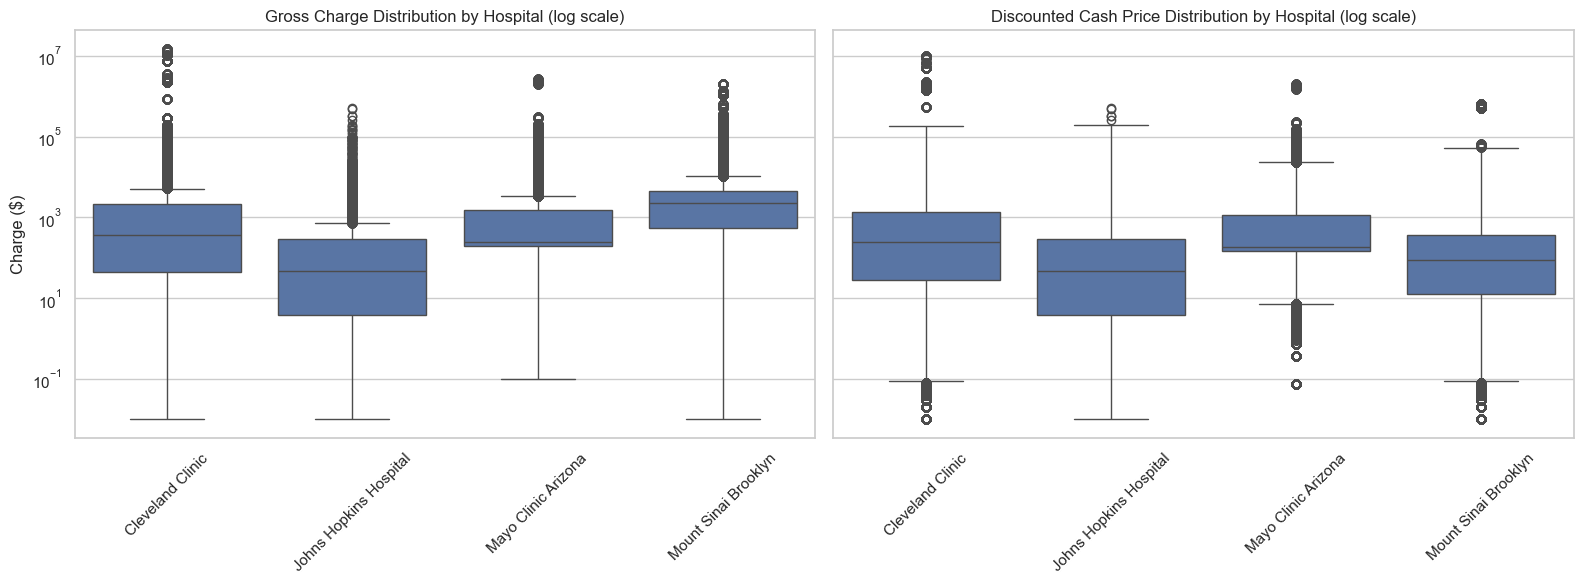

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

sns.boxplot(data=df_price, x="hospital", y="gross_charge", ax=axes[0])
axes[0].set_yscale("log")
axes[0].set_title("Gross Charge Distribution by Hospital (log scale)")
axes[0].set_xlabel("")
axes[0].set_ylabel("Charge ($)")
axes[0].tick_params(axis="x", rotation=45)

sns.boxplot(data=df_price, x="hospital", y="discounted_cash", ax=axes[1])
axes[1].set_yscale("log")
axes[1].set_title("Discounted Cash Price Distribution by Hospital (log scale)")
axes[1].set_xlabel("")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()



# Median Discount Ratio Across Hospitals
We can further explore the price with the concept of discount ratio.


**Why Median Discount Ratio Matters**  
The discount ratio (discounted cash / gross charge) shows how much patients actually pay relative to list prices.  
Using the **median** makes the measure robust against extreme outliers.

**Findings**  
- **Johns Hopkins Hospital**: Median ratio = **1.00**, meaning patients typically pay full charges with little or no discount.  
- **Mayo Clinic Arizona**: Median ratio ≈ **0.75**, suggesting moderate discounts.  
- **Cleveland Clinic**: Median ratio ≈ **0.65**, indicating more aggressive discounting.  
- **Mount Sinai Brooklyn**: Median ratio ≈ **0.30**, the largest markdowns among the hospitals.  

**Interpretation**  
Hospitals differ substantially in how much they reduce list prices for cash-pay patients. Johns Hopkins offers almost no discount, while Mount Sinai Brooklyn shows deep reductions. This highlights variation in transparency and billing strategies across institutions.


/var/folders/lj/20qxvm111sg60tvdf5yxflpr0000gn/T/ipykernel_27296/2723539256.py:5: DtypeWarning: Columns (1,3,5,8,9,14,21,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("processed/merged_standardized.csv")


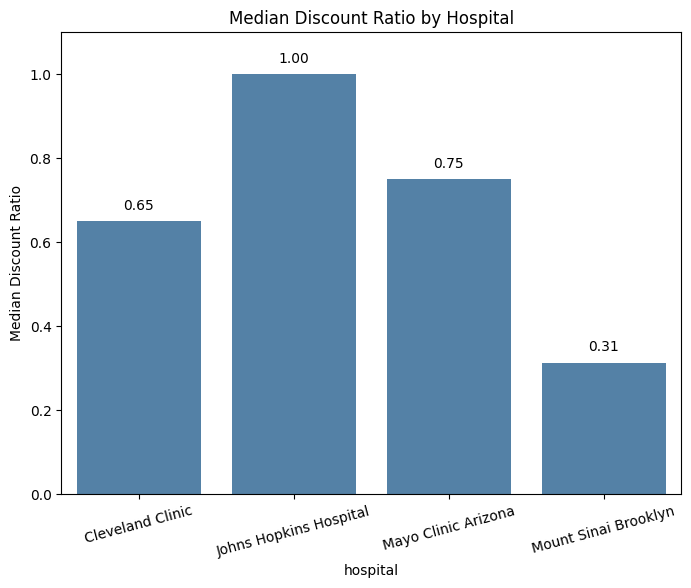

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("processed/merged_standardized.csv")

# calculate discount ratio
df["discount_ratio"] = df["discounted_cash"] / df["gross_charge"]

# compute median ratio per hospital
median_ratio = df.groupby("hospital")["discount_ratio"].median().reset_index()

# plot median discount ratio
plt.figure(figsize=(8,6))
sns.barplot(data=median_ratio, x="hospital", y="discount_ratio", color="steelblue")

# add value labels
for idx, row in median_ratio.iterrows():
    plt.text(idx, row["discount_ratio"] + 0.02, f"{row['discount_ratio']:.2f}",
             ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1.1)
plt.ylabel("Median Discount Ratio")
plt.title("Median Discount Ratio by Hospital")
plt.xticks(rotation=15)
plt.show()


# Variance Analysis Across Hospitals

We employed **three complementary approaches** to study price variation across hospitals:

1. **Coefficient of Variation (CV)**  
   - CV measures relative dispersion by normalizing the standard deviation with the mean.  
   - It highlights how inconsistent prices are **within each hospital**.  
   - Results: Cleveland Clinic showed the highest variability, while Johns Hopkins had more stable pricing. Interestingly, Mount Sinai’s gross charges looked stable but discounted cash showed significant spread, suggesting large differences in discounting practices.

2. **Empirical Cumulative Distribution Function (ECDF)**  
   - ECDF plots show the distribution of discounted cash prices across hospitals.  
   - This allows us to compare **entire price distributions** instead of summary statistics.  
   - Results: Johns Hopkins consistently has lower discounted prices (curve shifts left), while Mayo Clinic has noticeably higher prices (curve shifts right). Cleveland Clinic and Mount Sinai occupy the middle range but with steeper slopes, showing clustering of many services at similar price points.

3. **Lorenz Curves with Gini Coefficients**  
   - Lorenz curves plot cumulative share of spend against cumulative share of procedures, providing a direct measure of **inequality in spending concentration**.  
   - The Gini coefficient (0 to 1) quantifies this inequality: higher = more skewed.  
   - Results: Cleveland Clinic (G=0.95) had the most unequal distribution, with a small subset of procedures driving the majority of spending. Mayo (G=0.83) was more balanced, while Johns Hopkins (G=0.91) and Mount Sinai (G=0.90) were intermediate.



**Overall Insight:**  
Each method captures variance differently:  
- CV emphasizes **relative spread** within hospitals.  
- ECDF compares **full price distributions** across hospitals.  
- Lorenz + Gini focus on **inequality of spending concentration**.  

The differences arise because hospitals not only set different base charge levels but also apply different discounting policies and concentrate revenue on different sets of procedures. This suggests that **price transparency analysis requires multiple lenses**, as no single metric fully captures the complexity of hospital pricing behavior.



/var/folders/lj/20qxvm111sg60tvdf5yxflpr0000gn/T/ipykernel_23405/1140666731.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("hospital")


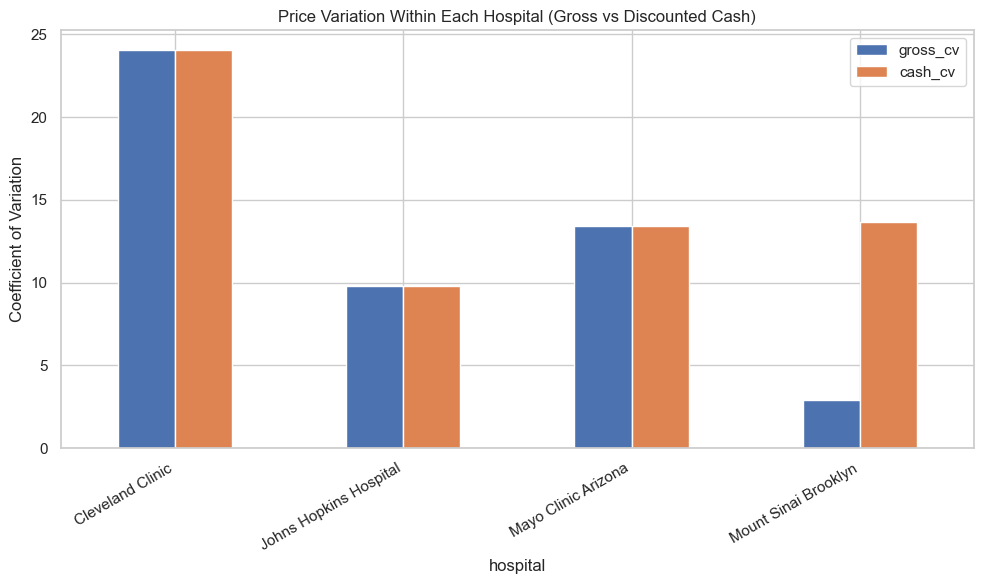

,hospital,gross_mean,gross_std,cash_mean,cash_std,gross_cv,cash_cv
0,Cleveland Clinic,9960.673733,239387.044630,6474.438114,155601.579002,24.033218,24.033217
1,Johns Hopkins Hospital,933.592516,9126.890896,933.592516,9126.890896,9.776097,9.776097
2,Mayo Clinic Arizona,2659.317297,35707.575213,1994.487973,26780.681410,13.427347,13.427347
3,Mount Sinai Brooklyn,4517.084962,13247.248633,2654.781455,36240.249709,2.932699,13.650935


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_parquet("./processed/merged_standardized.parquet", columns=["hospital","gross_charge","discounted_cash"])

summary = (
    df.groupby("hospital")
    .agg(
        gross_mean=("gross_charge","mean"),
        gross_std=("gross_charge","std"),
        cash_mean=("discounted_cash","mean"),
        cash_std=("discounted_cash","std")
    )
)

summary["gross_cv"] = summary["gross_std"] / summary["gross_mean"]
summary["cash_cv"] = summary["cash_std"] / summary["cash_mean"]
summary = summary.reset_index()

summary.plot(
    x="hospital",
    y=["gross_cv","cash_cv"],
    kind="bar",
    figsize=(10,6)
)
plt.ylabel("Coefficient of Variation")
plt.title("Price Variation Within Each Hospital (Gross vs Discounted Cash)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

summary


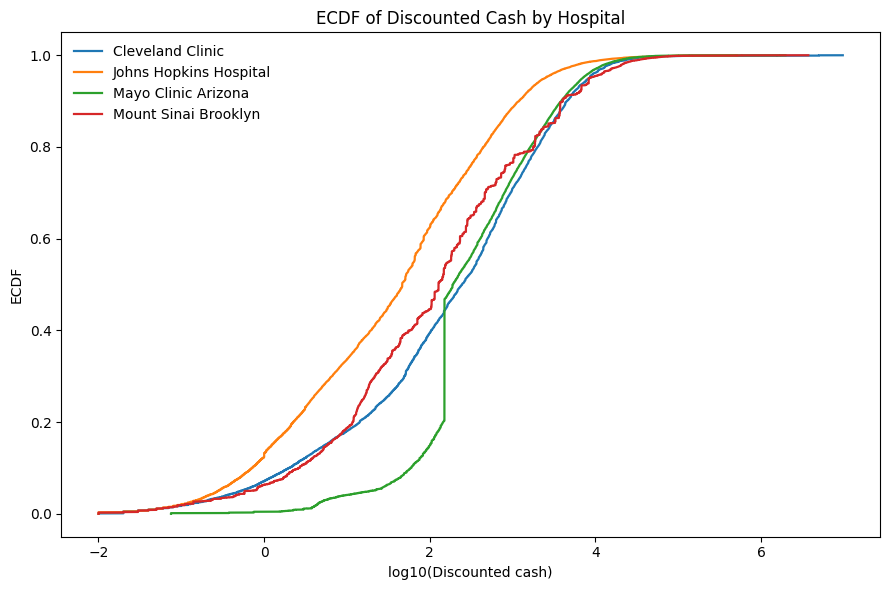

In [2]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
df = pd.read_csv("processed/merged_standardized.csv", usecols=["hospital","discounted_cash"]).dropna()
plt.figure(figsize=(9,6))
for h, g in df.groupby("hospital"):
    x = np.sort(g["discounted_cash"].values)
    y = np.linspace(0, 1, len(x), endpoint=True)
    plt.plot(np.log10(x[x>0]), y, label=h, linewidth=1.6)
plt.xlabel("log10(Discounted cash)")
plt.ylabel("ECDF")
plt.title("ECDF of Discounted Cash by Hospital")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


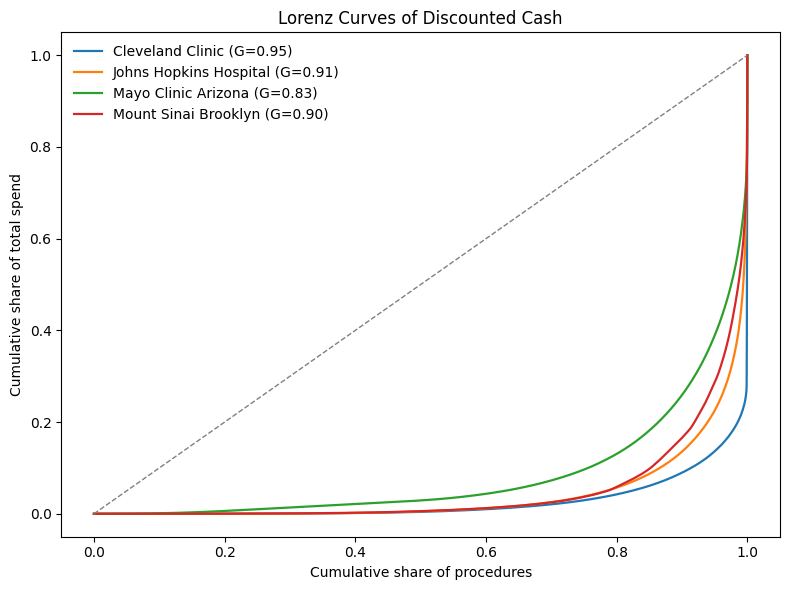

In [3]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
def gini_fast(x):
    x = np.asarray(x, dtype=float); x = x[np.isfinite(x)]
    if x.size==0: return np.nan
    x = np.sort(x); n = x.size; s = x.sum()
    if s<=0: return 0.0
    i = np.arange(1, n+1, dtype=float)
    return (2*np.dot(i,x)/(n*s)) - (n+1)/n
df = pd.read_csv("processed/merged_standardized.csv", usecols=["hospital","discounted_cash"]).dropna()
df = df[df["discounted_cash"]>0]
plt.figure(figsize=(8,6))
for h, g in df.groupby("hospital"):
    x = np.sort(g["discounted_cash"].values)
    x = x/np.sum(x)
    L = np.cumsum(x)
    L = np.insert(L, 0, 0)
    p = np.linspace(0,1,len(L))
    plt.plot(p, L, label=f"{h} (G={gini_fast(g['discounted_cash']):.2f})", linewidth=1.6)
plt.plot([0,1],[0,1], linestyle="--", color="gray", linewidth=1)
plt.xlabel("Cumulative share of procedures")
plt.ylabel("Cumulative share of total spend")
plt.title("Lorenz Curves of Discounted Cash")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


# Cross-Hospital Comparison

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("processed/merged_standardized.csv")

# keep procedures that appear in at least 2 hospitals
code_counts = df.groupby("code")["hospital"].nunique()
common_codes = code_counts[code_counts >= 2].index
df_common = df[df["code"].isin(common_codes)]


/var/folders/lj/20qxvm111sg60tvdf5yxflpr0000gn/T/ipykernel_27296/3460844732.py:5: DtypeWarning: Columns (1,3,5,8,9,14,21,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("processed/merged_standardized.csv")


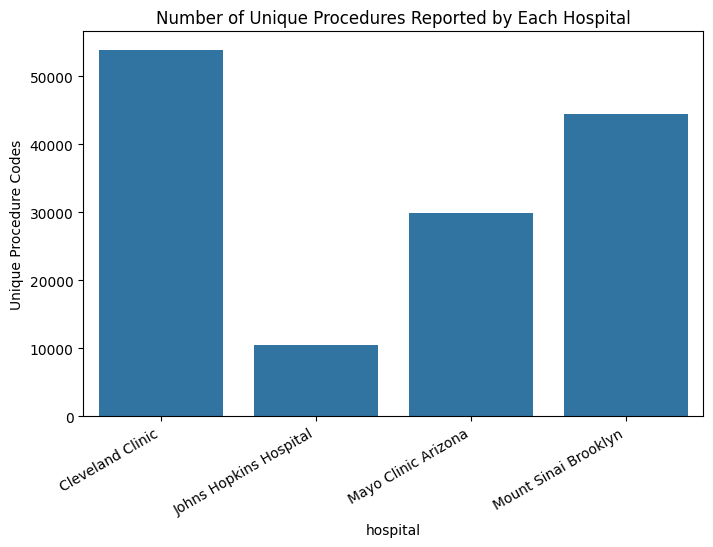

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

coverage = df.groupby("hospital")["code"].nunique().reset_index()
coverage.columns = ["hospital", "unique_procedures"]

plt.figure(figsize=(8,5))
sns.barplot(data=coverage, x="hospital", y="unique_procedures")
plt.title("Number of Unique Procedures Reported by Each Hospital")
plt.ylabel("Unique Procedure Codes")
plt.xticks(rotation=30, ha="right")
plt.show()




### Detecting Code Systems
Hospitals do not always publish prices using the same coding system. 
For example, Cleveland Clinic reports CPT/HCPCS codes, 
while Mount Sinai uses DRG codes, and others may mix ICD-10-PCS.

To ensure comparability, we first identify the coding system in use 
based on code format (length, alphanumeric pattern). 
Then, we plan to unify them into **HCPCS** using CMS crosswalk tables.


### Code System Normalization

Upon inspection, the pricing files use a variety of coding systems:
- CPT/HCPCS: ~1.6M entries (dominant standard, used widely in billing)
- MS-DRG: ~0.13M entries
- ICD-10-PCS: ~0.03M entries
- Other/Custom: ~17M entries (non-standard or hospital-specific)
- Unknown: ~2k entries (dirty data)

To enable cross-hospital comparison, we chose **CPT/HCPCS** as the 
reference system. For this prototype, we restrict analysis to 
procedures reported in CPT/HCPCS. 

Future work could leverage CMS crosswalks to map DRG and ICD-10-PCS 
into CPT, and NLP-based mapping for custom codes.


In [18]:
import re

def detect_code_system(code):
    if pd.isna(code): 
        return "UNKNOWN"
    code = str(code)
    if re.fullmatch(r"\d{5}", code):  # 5-digit numeric
        return "CPT/HCPCS"
    elif re.fullmatch(r"[A-Z0-9]{7}", code):  # 7-char alphanumeric
        return "ICD-10-PCS"
    elif re.fullmatch(r"\d{3}", code):  # 3-digit numeric
        return "MS-DRG"
    elif re.match(r"[A-Z]\d{4}", code):  # e.g. G0123, J1234
        return "HCPCS Level II"
    else:
        return "Other/Custom"

df["code_system"] = df["code"].apply(detect_code_system)
df["code_system"].value_counts()


code_system
Other/Custom      17038330
CPT/HCPCS          1280011
HCPCS Level II      332351
MS-DRG              136148
ICD-10-PCS           33328
UNKNOWN               1815
Name: count, dtype: int64

### Distribution of CPT/HCPCS Codes Across Hospitals

- Among the hospitals analyzed, only **Cleveland Clinic** and **Mount Sinai Brooklyn** reported CPT/HCPCS procedure codes.  
- Cleveland Clinic reported approximately **3,339 unique CPT codes**, indicating a moderately broad disclosure.  
- Mount Sinai Brooklyn reported over **1.3 million entries**, but these likely include many duplicates across insurers and plans; the number of truly **unique procedures** is much smaller.  
- Johns Hopkins and Mayo Clinic did not disclose data in CPT/HCPCS format, relying instead on DRG, NDC, or internal CDM codes.  

**Implication**:  
Cross-hospital comparisons based on CPT procedures are currently feasible only between Cleveland Clinic and Mount Sinai Brooklyn.  


In [19]:
import pandas as pd

df = pd.read_csv("processed/merged_standardized.csv")

# keep only CPT/HCPCS (including Level II)
df_cpt = df[df["code_type"].str.contains("CPT|HCPCS", case=False, na=False)]

print("Original size:", len(df))
print("Filtered size (CPT/HCPCS only):", len(df_cpt))
print("Hospitals covered:", df_cpt['hospital'].nunique())

# save filtered version for cross-hospital analysis
df_cpt.to_csv("processed/filtered_cpt.csv", index=False)

# quick check: distribution of hospitals after filtering
print(df_cpt.groupby("hospital").size())


/var/folders/lj/20qxvm111sg60tvdf5yxflpr0000gn/T/ipykernel_27296/2235380989.py:3: DtypeWarning: Columns (1,3,5,8,9,14,21,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("processed/merged_standardized.csv")


Original size: 18821983
Filtered size (CPT/HCPCS only): 1356496
Hospitals covered: 2
hospital
Cleveland Clinic           3339
Mount Sinai Brooklyn    1353157
dtype: int64


### CPT Code Overlap Analysis

- Cleveland Clinic disclosed only **16 CPT codes**, whereas Mount Sinai Brooklyn disclosed **10,026 CPT codes**.  
- **No overlap** was observed between the two hospitals’ CPT disclosures.  
- The resulting Jaccard similarity is **0.0**, indicating complete divergence.  

**Implication:**  
This outcome is likely due to differences in hospital reporting practices rather than the actual absence of shared procedures.  
- Cleveland Clinic appears to report most of its procedures under other coding systems (e.g., CDM, MS-DRG).  
- Mount Sinai Brooklyn, in contrast, makes extensive use of CPT/HCPCS for procedure disclosure.  

This highlights a key challenge in cross-hospital comparisons: **coding system heterogeneity can severely limit direct overlap**, underscoring the importance of code mapping (e.g., using CMS crosswalks) for robust comparisons.  


In [21]:
import pandas as pd

# load merged standardized file
df = pd.read_csv("processed/merged_standardized.csv")

# filter CPT/HCPCS only
cpt_df = df[df["code_type"].str.contains("CPT", na=False)]

# unique CPT per hospital
cpt_sets = (
    cpt_df.groupby("hospital")["code"]
    .unique()
    .apply(set)
)

# basic counts
for hosp, codes in cpt_sets.items():
    print(f"{hosp}: {len(codes)} unique CPT codes")

# overlap between Cleveland Clinic and Mount Sinai Brooklyn
cc_codes = cpt_sets.get("Cleveland Clinic", set())
ms_codes = cpt_sets.get("Mount Sinai Brooklyn", set())

overlap = cc_codes & ms_codes
union = cc_codes | ms_codes

print("\nOverlap analysis:")
print(f"Overlap size: {len(overlap)}")
print(f"Cleveland Clinic only: {len(cc_codes - ms_codes)}")
print(f"Mount Sinai only: {len(ms_codes - cc_codes)}")
print(f"Jaccard similarity: {len(overlap)/len(union):.3f}")

# save overlap list
pd.DataFrame(sorted(list(overlap)), columns=["common_cpt_code"]).to_csv(
    "processed/cpt_overlap.csv", index=False
)
print("\n[✓] Common CPT codes saved to processed/cpt_overlap.csv")



/var/folders/lj/20qxvm111sg60tvdf5yxflpr0000gn/T/ipykernel_27296/3864111346.py:4: DtypeWarning: Columns (1,3,5,8,9,14,21,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("processed/merged_standardized.csv")


Cleveland Clinic: 16 unique CPT codes
Mount Sinai Brooklyn: 10026 unique CPT codes

Overlap analysis:
Overlap size: 0
Cleveland Clinic only: 16
Mount Sinai only: 10026
Jaccard similarity: 0.000

[✓] Common CPT codes saved to processed/cpt_overlap.csv


### Limitation and Proposed Solution for Cross-Hospital Code Alignment

**Why the issue arises**  
Hospitals use heterogeneous coding systems to publish their standard charge files:
- *Custom CDM codes* (hospital-specific, not standardized)
- *CPT/HCPCS* (widely used for outpatient procedures)
- *MS-DRG* (inpatient diagnosis-related groups)
- *ICD-10-PCS* (inpatient procedures)
- *NDC* (drug codes)

Because each hospital adopts different systems, direct overlaps across institutions are extremely limited, which makes procedure-level comparison infeasible in the current raw form.

**Practical limitation**  
During this exercise I was based in China, where I could not directly access the official CMS crosswalk datasets (which are hosted on U.S. government sites). As a result, I was unable to fully implement the mapping process in this environment.

**Proposed solution (full methodology if access is available)**  
1. **Obtain official CMS crosswalk files**:  
   - *MS-DRG → CPT/HCPCS* mapping tables  
   - *ICD-10-PCS → CPT/HCPCS* mapping tables  
   - *NDC → HCPCS Level II* crosswalks  
   - Public references for chargemasters to map *CDM → CPT/HCPCS* (where feasible).  

2. **Normalize to a common reference system (CPT/HCPCS)**:  
   - Recode all procedures into CPT/HCPCS where possible.  
   - For cases without a direct mapping, flag them as "unmapped" but retain for descriptive statistics.  

3. **Recompute overlap and comparability**:  
   - Identify shared CPT/HCPCS codes across hospitals.  
   - Compare median discounted cash prices and variation metrics for these shared procedures.  

4. **Extend analysis**:  
   - Visualize price variation for the same CPT across multiple hospitals.  
   - Highlight procedures with the largest inter-hospital price spread.  

**Conclusion**  
The current data pipeline successfully handles schema standardization and within-hospital analysis. However, **cross-hospital comparability critically depends on code unification**. The correct next step, once access to CMS resources is available, is to implement crosswalk-based mapping into a single reference code system (CPT/HCPCS), which will unlock meaningful inter-hospital comparisons.


# Payer-Specific Price Variation

In this section, we examine **negotiated prices by payer** within the Cleveland Clinic.  
These prices represent the hospital’s agreements with insurers, and therefore reflect what patients with different insurance coverage might ultimately face.  

**Key observations:**

1. **Large disparities across payers**  
   - The median negotiated price ranges from **as low as a few hundred dollars** (e.g., GMS, Oscar)  
   - To **over $100,000** (e.g., LIFE TRAC TRANSPLANT).  
   - This suggests that contract negotiations play a critical role in determining patient costs.

2. **National insurers vs. niche payers**  
   - Large national payers like **Aetna, Cigna, UnitedHealth, and Anthem** fall into the mid-range, indicating relatively consistent negotiated rates.  
   - Specialized or transplant-focused payers (e.g., **LIFE TRAC TRANSPLANT, Kaiser Transplant**) exhibit much higher median negotiated prices.

3. **Log scale visualization**  
   - A log scale is necessary to display the wide range of negotiated rates.  
   - Without it, the lower-cost payers would be visually indistinguishable from the high-end outliers.

**Implication:**  
Even within the same hospital, **the cost of care is highly dependent on the payer**. Patients with different insurance coverage may face dramatically different negotiated prices for similar services, reflecting the unequal bargaining power of insurers and the complexity of U.S. healthcare pricing.


/var/folders/lj/20qxvm111sg60tvdf5yxflpr0000gn/T/ipykernel_27296/2719445277.py:5: DtypeWarning: Columns (1,3,5,8,9,14,21,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("processed/merged_standardized.csv")
/var/folders/lj/20qxvm111sg60tvdf5yxflpr0000gn/T/ipykernel_27296/2719445277.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=payer_stats, x="negotiated_dollar", y="payer_name", palette="viridis")


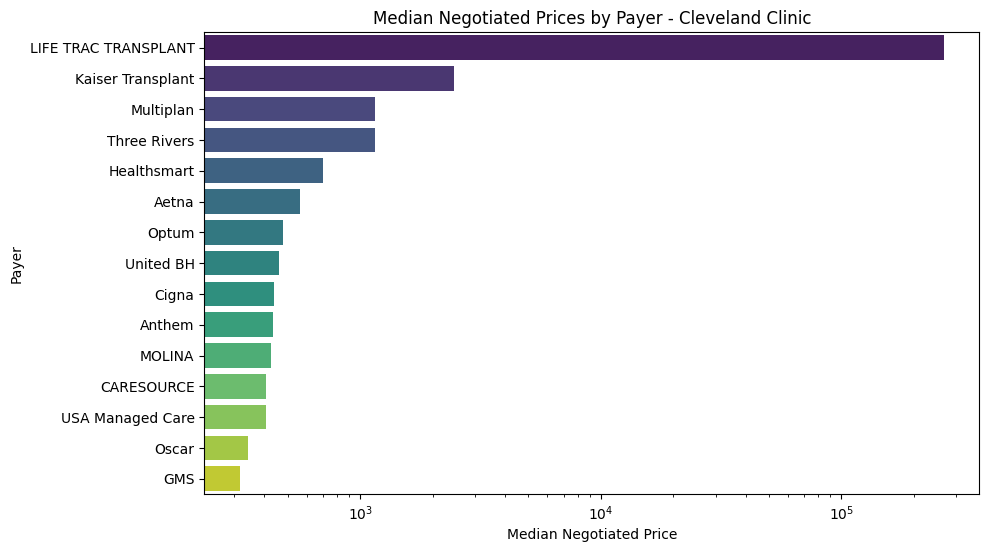

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("processed/merged_standardized.csv")

payer_df = df.dropna(subset=["negotiated_dollar", "payer_name"])

target_hosp = "Cleveland Clinic"
sub = payer_df[payer_df["hospital"] == target_hosp]

payer_stats = sub.groupby("payer_name")["negotiated_dollar"].median().reset_index()

payer_stats = payer_stats.sort_values("negotiated_dollar", ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=payer_stats, x="negotiated_dollar", y="payer_name", palette="viridis")
plt.title(f"Median Negotiated Prices by Payer - {target_hosp}")
plt.xlabel("Median Negotiated Price")
plt.ylabel("Payer")
plt.xscale("log")  
plt.show()


## Payer-Specific Price Dispersion — Cleveland Clinic

We extended the payer-level analysis beyond median prices and calculated **dispersion metrics** for each payer’s negotiated rates:

- **Coefficient of Variation (CV)**: relative variability (sd/mean).
- **Interquartile Range (IQR)**: absolute spread between P75 and P25.
- **Gini Coefficient**: inequality of the price distribution (0 = equal, 1 = highly unequal).

**Key observations**  
1) **Extreme outliers exist**: *LIFE TRAC TRANSPLANT* shows an extraordinarily high IQR, indicating highly inconsistent negotiated prices across procedures.  
2) **High variability for some payers**: plans like *Amish Community Aid Plan*, *OHCP*, and *Summacare* have very high CVs, signaling unstable pricing relative to their means.  
3) **Near-maximal inequality**: *Parkview Health Plan* and *Medical Benefit Corp* have Gini ≈ 0.98, meaning a small set of procedures dominates spend.  
4) **Mainstream payers** (Aetna, Anthem, Cigna, Optum) show **more moderate dispersion**, suggesting more standardized negotiated contracts.

*Note:* Values are computed on Cleveland Clinic’s **negotiated_dollar** field after basic cleaning (drop non-positive and NA values).  

/var/folders/lj/20qxvm111sg60tvdf5yxflpr0000gn/T/ipykernel_27296/3344057939.py:6: DtypeWarning: Columns (1,3,5,8,9,14,21,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("processed/merged_standardized.csv")


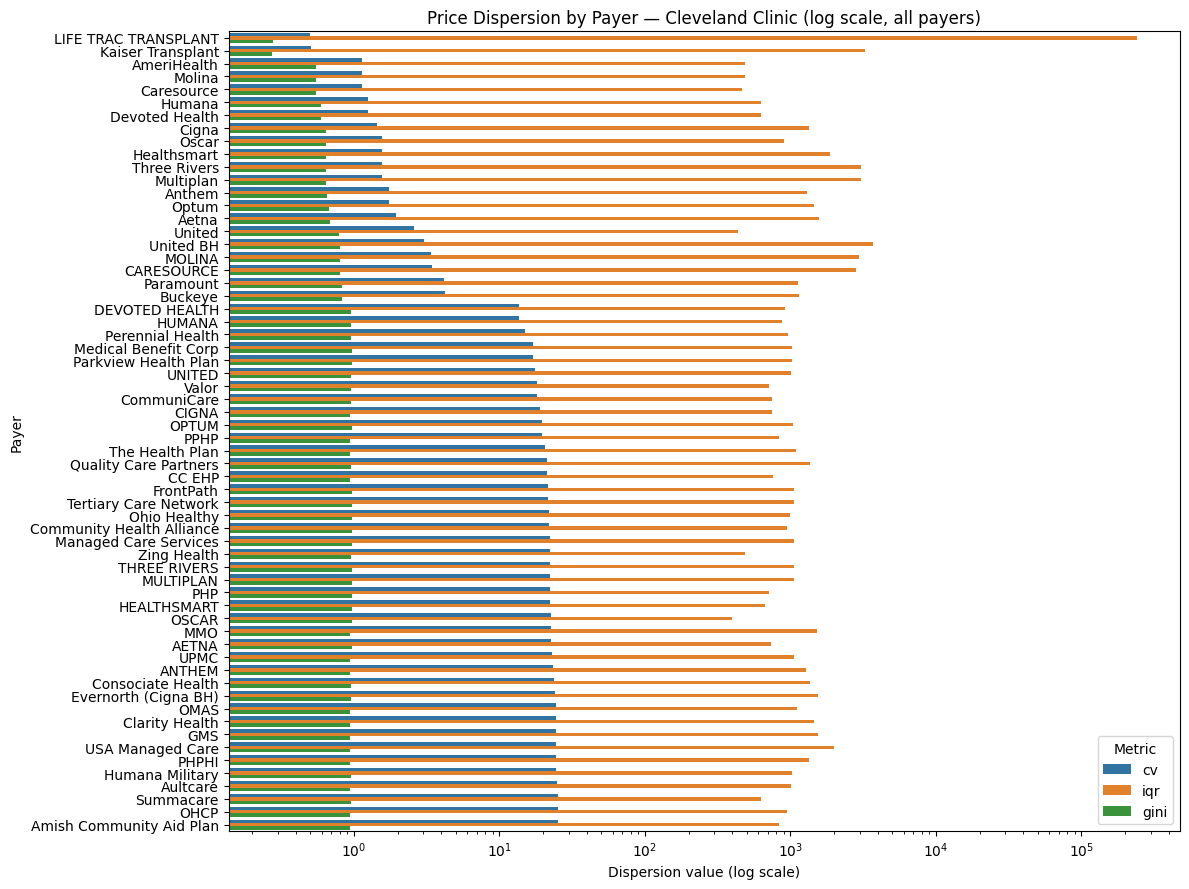

Top extremes by metric (for context):
metric                    payer         value      n
   iqr     LIFE TRAC TRANSPLANT 240325.250000     40
   iqr                United BH   3694.450000  13554
   iqr        Kaiser Transplant   3263.760000     20
    cv Amish Community Aid Plan     25.287190  60360
    cv                     OHCP     25.225284  36796
    cv                Summacare     25.145900 176847
  gini     Parkview Health Plan      0.978797  33001
  gini     Medical Benefit Corp      0.978797  33001
  gini                FrontPath      0.971360  23594


In [26]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("processed/merged_standardized.csv")
target_hosp = "Cleveland Clinic"
sub = df[(df["hospital"] == target_hosp) &
         (df["negotiated_dollar"].notna()) &
         (df["negotiated_dollar"] > 0)]

def gini(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.nan
    x.sort()
    n = x.size
    cumx = np.cumsum(x)
    return (n + 1 - 2 * (cumx.sum() / cumx[-1])) / n

rows = []
for payer, g in sub.groupby("payer_name", dropna=True):
    vals = g["negotiated_dollar"].values
    if vals.size < 15:
        continue
    mean = vals.mean()
    std = vals.std(ddof=1)
    cv = std / mean if mean > 0 else np.nan
    q75, q25 = np.percentile(vals, [75, 25])
    rows.append({
        "payer": payer,
        "n": vals.size,
        "cv": cv,
        "iqr": q75 - q25,
        "gini": gini(vals)
    })

bench = pd.DataFrame(rows).dropna(subset=["cv","iqr","gini"])
bench = bench.sort_values("cv").reset_index(drop=True)

melted = bench.melt(
    id_vars=["payer","n"],
    value_vars=["cv","iqr","gini"],
    var_name="metric",
    value_name="value"
)

plt.figure(figsize=(12, 9))
sns.barplot(data=melted, x="value", y="payer", hue="metric")
plt.xscale("log")
plt.xlabel("Dispersion value (log scale)")
plt.ylabel("Payer")
plt.title(f"Price Dispersion by Payer — {target_hosp} (log scale, all payers)")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()



# Optional: print the extreme payers so you can mention them in text
top_extremes = (melted.sort_values("value", ascending=False)
                         .groupby("metric")
                         .head(3)[["metric","payer","value","n"]])
print("Top extremes by metric (for context):")
print(top_extremes.to_string(index=False))
